In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import sklearn.metrics as metrics
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
import csv
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import train_test_split_edges
import torch_geometric.transforms as T
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data, DataLoader
from scipy import sparse
from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)
    
def train(epoch,val_pos, val_neg):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    AUC, AP = model.test(z, val_pos, val_neg)
    return AUC,AP,loss.item()
#     writer.add_scalar("loss", loss.item(), epoch)
    
def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
        loss = model.recon_loss(z,pos_edge_index)
    AUC, AP = model.test(z, pos_edge_index, neg_edge_index)
    return AUC,AP,loss.item()



In [26]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2', ...]

    @property
    def processed_file_names(self):
#         pass
        return ['data.pt']

#     def download(self):
#         pass
#         Download to `self.raw_dir`.

    def process(self):
        # Read data into huge `Data` list.
        
        graph= nx.read_graphml("../data/transactions_16-12-15.graphml")
        graph=nx.Graph(graph)
        print("graph loaded!!!", nx.info(graph))
        features = np.load("../data/transactions_16-12-15.npy", allow_pickle= True)
        edge_features = []
#         max_deg = sorted(list(dict(nx.degree(graph)).values()),reverse = True)[0]
#         range_ = 100
        X =  []
        for n in graph.nodes():
            f_vect = torch.zeros((100+1,),dtype = torch.float)
            deg = nx.degree(graph, n)
#             bin_ = int((deg/max_deg)*range_)
            if deg>100:
                deg = 100
            f_vect[deg] = 1
            X.append(f_vect)
        X = torch.stack(X) 
        dic = features.item()
        for k, v in dic.items():
            t = torch.zeros(len(v),dtype = torch.float)
            for index in range(len(v)):
                t[index] = float(v[index])
            edge_features.append(t)

        edge_features = torch.stack(edge_features) 
        pyg_g = pyg_utils.from_networkx(graph)
        pyg_g.x= X
        pyg_g.edge_attr = edge_features
        data_list = [pyg_g]
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        print("dataset: ",len(data_list))
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])



In [28]:
path = '../data/transactions_16-12-15/'
# transform = T.OneHotDegree(max_degree=2)
# dataset = MyOwnDataset(path,transform = transform)
dataset = MyOwnDataset(path)

In [71]:
# writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

# dataset = Planetoid(root='/tmp/cora', name='cora')
# task = 'node'

# model = train(dataset, task, writer)

data = dataset[0]

channels = 8
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())

# encoder: written by us; decoder: default (inner product)
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
print("data loaded successfully!!")
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data,val_ratio=0.0, test_ratio=0.33)
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("now training the model")
AUC_, AP_,AUC_train, AP_train,train_loss,test_loss = [],[],[],[],[],[]
for epoch in range(0, 100):
    AUC_tr, AP_tr,tr_loss = train(epoch,data.test_pos_edge_index, data.test_neg_edge_index)
    AUC_train.append(AUC_tr)
    AP_train.append(AP_tr)
    auc, ap,test_l= test(data.test_pos_edge_index, data.test_neg_edge_index)
    AUC_.append(auc)
    AP_.append(ap)
    train_loss.append(tr_loss)
    test_loss.append(test_l)
    writer.add_scalar("AUC", auc, epoch)
    writer.add_scalar("AP", ap, epoch)
#     if epoch % 10 == 0:
    print('Epoch: {:03d}, AUC_train: {:.4f},AUC_test:{:.4f} loss_train: {:.4f}, loss_test:{:.4f}'.format(epoch, AUC_tr, auc,tr_loss, test_l))

CUDA availability: False
data loaded successfully!!
now training the model
Epoch: 000, AUC_train: 0.8738,AUC_test:0.8757 loss_train: 1.3062, loss_test:1.2805
Epoch: 001, AUC_train: 0.8757,AUC_test:0.8775 loss_train: 1.3007, loss_test:1.2741
Epoch: 002, AUC_train: 0.8775,AUC_test:0.8793 loss_train: 1.2950, loss_test:1.2673
Epoch: 003, AUC_train: 0.8793,AUC_test:0.8809 loss_train: 1.2893, loss_test:1.2605
Epoch: 004, AUC_train: 0.8809,AUC_test:0.8822 loss_train: 1.2833, loss_test:1.2537
Epoch: 005, AUC_train: 0.8822,AUC_test:0.8836 loss_train: 1.2771, loss_test:1.2464
Epoch: 006, AUC_train: 0.8836,AUC_test:0.8848 loss_train: 1.2707, loss_test:1.2390
Epoch: 007, AUC_train: 0.8848,AUC_test:0.8862 loss_train: 1.2640, loss_test:1.2315
Epoch: 008, AUC_train: 0.8862,AUC_test:0.8879 loss_train: 1.2571, loss_test:1.2237
Epoch: 009, AUC_train: 0.8879,AUC_test:0.8901 loss_train: 1.2499, loss_test:1.2158
Epoch: 010, AUC_train: 0.8901,AUC_test:0.8925 loss_train: 1.2425, loss_test:1.2076
Epoch: 011, 

Epoch: 098, AUC_train: 0.9778,AUC_test:0.9777 loss_train: 0.9478, loss_test:0.9477
Epoch: 099, AUC_train: 0.9777,AUC_test:0.9776 loss_train: 0.9476, loss_test:0.9461


In [77]:
file = open("results_transactions_16-12-15.csv",'a',newline = '')
res_writer = csv.writer(file, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
res_writer.writerow(["sequence => auc_train","auc_test","ap_train","ap_test","train loss","test loss"])
res_writer.writerow(AUC_train)
res_writer.writerow(AUC_)
res_writer.writerow(AP_train)
res_writer.writerow(AP_)
res_writer.writerow(train_loss)
res_writer.writerow(test_loss)
file.flush()
file.close()

In [50]:
acc  = pd.read_csv("results_transactions_16-12-15.csv")


In [51]:
acc.head()


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,sequence => auc,ap,train loss,test loss
0.892721,0.895542,0.898135,0.900672,0.903067,0.905314,0.907406,0.909412,0.911398,0.913282,0.915127,0.916966,0.918782,0.920560,0.922229,0.923888,0.925492,0.927078,0.928640,0.930110,0.931533,0.932959,0.934364,0.935725,0.937010,0.938276,0.939511,0.940744,0.941916,0.943064,0.944138,0.945169,0.946109,0.947030,0.947889,0.948712,0.949506,0.950266,0.950978,0.951663,0.952335,0.952985,0.953604,0.954221,0.954802,0.955347,0.955876,0.956375,0.956840,0.957320,0.957778,0.958229,0.958632,0.958988,0.959351,0.959668,0.959972,0.960286,0.960611,0.960928,0.961216,0.961510,0.961776,0.962036,0.962275,0.962497,0.962691,0.962884,0.963075,0.963235,0.963400,0.963539,0.963680,0.963790,0.963856,0.963921,0.963956,0.964015,0.964086,0.964136,0.964188,0.964246,0.964277,0.964286,0.964269,0.964258,0.964255,0.964232,0.964207,0.964182,0.964130,0.964066,0.963977,0.963883,0.963782,0.963646,0.963485,0.963279,0.963056,0.962798
0.925273,0.927253,0.929075,0.930778,0.932378,0.933885,0.935294,0.936601,0.937890,0.939083,0.940236,0.941381,0.942481,0.943547,0.944534,0.945515,0.946444,0.947349,0.948251,0.949086,0.949894,0.950700,0.951486,0.952262,0.952995,0.953710,0.954414,0.955122,0.955791,0.956456,0.957082,0.957695,0.958272,0.958840,0.959389,0.959913,0.960423,0.960919,0.961400,0.961868,0.962333,0.962791,0.963235,0.963676,0.964118,0.964543,0.964962,0.965371,0.965765,0.966167,0.966563,0.966961,0.967338,0.967694,0.968052,0.968388,0.968709,0.969037,0.969365,0.969685,0.969989,0.970291,0.970573,0.970835,0.971095,0.971355,0.971600,0.971832,0.972069,0.972290,0.972511,0.972709,0.972898,0.973074,0.973161,0.973309,0.973420,0.973551,0.973677,0.973791,0.973911,0.974030,0.974125,0.974175,0.974231,0.974288,0.974338,0.974369,0.974410,0.974444,0.974461,0.974452,0.974429,0.974392,0.974357,0.974299,0.974235,0.974116,0.974002,0.973868
1.194668,1.185384,1.176213,1.166910,1.157757,1.148672,1.139678,1.130783,1.122024,1.113388,1.105132,1.096958,1.088786,1.081207,1.073974,1.066563,1.059752,1.052890,1.046992,1.041044,1.035320,1.030039,1.025384,1.020617,1.016634,1.012810,1.009319,1.006049,1.003477,1.000643,0.997872,0.995478,0.993659,0.991624,0.989960,0.988485,0.987255,0.985285,0.984498,0.983328,0.981537,0.980582,0.980162,0.979049,0.978255,0.976891,0.976595,0.975381,0.974533,0.973374,0.973373,0.971574,0.970749,0.970103,0.969961,0.969000,0.968579,0.966885,0.966441,0.965166,0.964275,0.963421,0.962366,0.960865,0.959854,0.958497,0.958299,0.957124,0.956379,0.955908,0.955165,0.953498,0.953373,0.952071,0.950888,0.948549,0.948612,0.948627,0.947004,0.946441,0.945149,0.943711,0.942476,0.942628,0.942392,0.940227,0.939828,0.938238,0.937353,0.936574,0.935329,0.936678,0.934607,0.934182,0.932870,0.931963,0.931381,0.930153,0.929200,0.928945
1.179195,1.169758,1.160381,1.151217,1.141869,1.132675,1.123706,1.114876,1.106365,1.097961,1.089950,1.081762,1.074078,1.066535,1.060578,1.052866,1.046596,1.040132,1.035048,1.029382,1.024501,1.019924,1.015563,1.012053,1.008666,1.004971,1.001362,0.998694,0.996571,0.994519,0.992545,0.990644,0.988867,0.987201,0.986447,0.985121,0.983711,0.982218,0.982174,0.980697,0.980608,0.978478,0.978315,0.978873,0.976886,0.976552,0.976206,0.975657,0.974908,0.972921,0.973559,0.973503,0.972434,0.971689,0.970218,0.969716,0.968184,0.968866,0.966648,0.966283,0.965822,0.964199,0.964473,0.962441,0.961506,0.962325,0.959406,0.960050,0.958947,0.957698,0.957090,0.957319,0.955953,0.954854,0.954989,0.953014,0.952578,0.952159,0.952109,0.949917,0.951099,0.948184,0.948502,0.947121,0.948197,0.948533,0.948244,0.946241,0.946748,0.944742,0.945667,0.945702,0.942592,0.944284,0.942611,0.942426,0.940819,0.941624,0.940940,0.942403


In [68]:
ls = []
for index,row in acc.iterrows():
    ls.append(list(index))


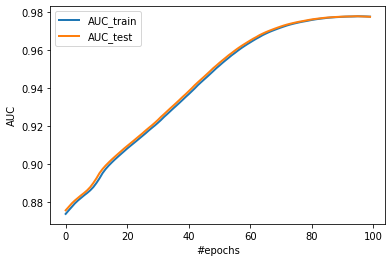

In [73]:
fig = plt.figure()
plt.plot(AUC_train,linewidth=2, label = 'AUC_train')
plt.plot(AUC_,linewidth=2, label = 'AUC_test')
plt.legend()
plt.xlabel("#epochs")
plt.ylabel("AUC")
plt.show()
fig.savefig("../figures/transactions_16-12-15_AUC_curves1.pdf")

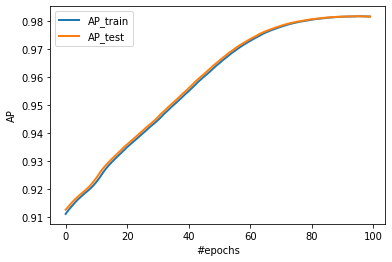

In [74]:
fig = plt.figure()
plt.plot(AP_train,linewidth=2, label = 'AP_train')
plt.plot(AP_,linewidth=2, label = 'AP_test')
plt.legend()
plt.xlabel("#epochs")
plt.ylabel("AP")
plt.show()
fig.savefig("../figures/transactions_16-12-15_AP_curves1.pdf")

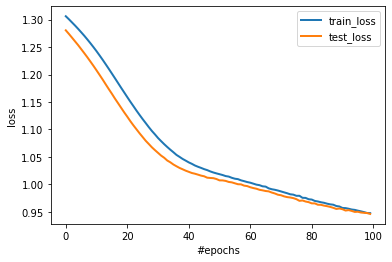

In [76]:
fig = plt.figure()
plt.plot(train_loss,linewidth=2, label = 'train_loss')
plt.plot(test_loss,linewidth=2, label = 'test_loss')
plt.legend()
plt.xlabel("#epochs")
plt.ylabel("loss")
plt.show()
fig.savefig("../figures/transactions_16-12-15_loss_curves1.pdf")

In [21]:
graph= nx.read_graphml("../data/transactions_16-12-15.graphml")
graph=nx.Graph(graph)
print("graph loaded!!!", nx.info(graph))
# deg = sorted(list(dict(nx.degree(graph)).values()),reverse = True)

graph loaded!!! Name: 
Type: Graph
Number of nodes: 37175
Number of edges: 56987
Average degree:   3.0659


In [5]:
# print(deg[:-10])

[4923, 4154, 3399, 3306, 2632, 1695, 1682, 1306, 989, 931, 923, 919, 857, 811, 803, 683, 619, 525, 482, 442, 374, 351, 350, 348, 336, 306, 305, 289, 288, 277, 260, 251, 230, 220, 213, 205, 192, 189, 188, 186, 174, 174, 165, 157, 148, 131, 126, 117, 117, 110, 107, 105, 104, 98, 97, 97, 95, 87, 86, 84, 83, 82, 79, 74, 73, 73, 71, 68, 66, 65, 65, 63, 63, 55, 54, 54, 54, 53, 52, 52, 51, 51, 50, 50, 49, 48, 48, 47, 47, 44, 43, 43, 42, 41, 40, 40, 39, 39, 39, 38, 38, 37, 37, 37, 37, 36, 35, 35, 34, 33, 33, 32, 32, 32, 31, 31, 30, 30, 30, 29, 28, 28, 28, 27, 27, 27, 26, 26, 26, 26, 26, 25, 25, 24, 24, 24, 23, 23, 23, 23, 23, 23, 22, 22, 22, 22, 21, 21, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13